# Objetivo

Rodar o modelo final na base de treino + validação e depois aplicação na base de teste;

Avaliar se a distribuição das probabilidades finais na base de treino + validação se mantém na base de teste;

Avaliar a curva de Perfil de Eficiência Acumulada (CAP) na base de tese;

Avaliar a distribuição das observações nas categorias das variáveis na base de treino + validação e em teste (PSI).

# Pacotes

In [1]:
from deltalake import DeltaTable, write_deltalake
import Funcoes
import pickle
import os
import numpy as np
import math
from scipy.stats import ks_2samp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, average_precision_score, brier_score_loss, confusion_matrix, ConfusionMatrixDisplay, log_loss

# Leitura das bases

In [2]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver', 
            'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Gender_M',
            'Dependent_count'], axis=1, inplace=True)
dados.head()

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,Income_Category_1.< 40k,Income_Category_2. >= 40k & < 60k,Income_Category_3. >= 60k & < 80k,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,1,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,0,0,0,1,0,0,0,1,0,0,Treino
2,1.346848,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,0,0,0,1,0,0,0,0,1,0,Treino
3,0.218648,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,1,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,1,0,0,0,0,1,0,0,0,0,Treino


## Separa bases

In [3]:
dados_treino_val = dados[dados.type != 'Teste'].drop(['type'], axis=1)
dados_teste = dados[dados.type == 'Teste'].drop(['type'], axis=1)

In [4]:
X_treino_val = dados_treino_val.drop(['Attrition_Flag'], axis=1)
y_treino_val = dados_treino_val['Attrition_Flag']

X_teste = dados_teste.drop(['Attrition_Flag'], axis=1)
y_teste = dados_teste['Attrition_Flag']

In [5]:
X_treino_val_new = X_treino_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_teste_new = X_teste.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

# RF

## Log do melhor modelo RF

In [18]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri='http://127.0.0.1:5000')
parametros = mlflow_client.get_run('c189498258a44951985fd8b97a019cf2').data.to_dictionary()['params']

In [38]:
parametros

{'verbose': '0',
 'min_weight_fraction_leaf': '0.0',
 'n_estimators': '437',
 'min_samples_leaf': '39',
 'min_impurity_decrease': '0.0',
 'max_samples': 'None',
 'ccp_alpha': '0.0',
 'max_features': 'sqrt',
 'oob_score': 'False',
 'warm_start': 'False',
 'max_leaf_nodes': 'None',
 'max_depth': '248',
 'min_samples_split': '233',
 'n_jobs': 'None',
 'criterion': 'gini',
 'monotonic_cst': 'None',
 'random_state': 'None',
 'bootstrap': 'True',
 'class_weight': 'None'}

Treino do melho conjunto de hiperparâmetros na base de treino e validação.

In [53]:
clf = RandomForestClassifier(n_estimators=437,
                             min_samples_leaf=39,
                             verbose=0,
                             min_weight_fraction_leaf=0,
                             min_impurity_decrease=0,
                             max_samples=None,
                             ccp_alpha=0,
                             max_features='sqrt',
                             oob_score=False,
                             warm_start=False,
                             max_leaf_nodes=None,
                             max_depth=248,
                             min_samples_split=233,
                             n_jobs=None,
                             criterion='gini',
                             monotonic_cst=None,
                             random_state=None,
                             bootstrap=True,
                             class_weight=None) 
clf.fit(X_treino_val_new, y_treino_val)

RandomForestClassifier(ccp_alpha=0, max_depth=248, min_impurity_decrease=0,
                       min_samples_leaf=39, min_samples_split=233,
                       min_weight_fraction_leaf=0, n_estimators=437)

Cria um experimento para logar o modelo final, rodado na base de treino e validação.

In [54]:
experiment = mlflow.create_experiment(name = 'Modelos_Finais',
                                      artifact_location = 'Modelos_Finais',
                                      tags = {'Environment': 'Pre_Deploy', 'Version': '1.0.0'}
                                      )

In [ ]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'RF_Final', experiment_id = experiment) as run: 

        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_teste_new, clf.predict_proba(X_teste_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Chamada do modelo RF construído anteriormente.

In [6]:
log_RF = 'runs:/49c8f322c903413b89a06aa02e2e3a4a/modelo'
clf = mlflow.sklearn.load_model(log_RF)

In [7]:
print('Auc_Pr_Teste:', average_precision_score(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('Auc_Roc_Teste:', roc_auc_score(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('BS_Teste:', brier_score_loss(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('Log_Loss_Teste:', log_loss(y_teste, clf.predict_proba(X_teste_new)[:,1]))

print('-------------------------------Sem ponto de corte ótimo-------------------------------')

# Sem ponto de corte ótimo
print('F1_Score_Teste:', f1_score(y_teste, clf.predict(X_teste_new)))
print('Precisao_Teste:', precision_score(y_teste, clf.predict(X_teste_new)))
print('Recall_Teste:', recall_score(y_teste, clf.predict(X_teste_new)))

print('-------------------------------Com ponto de corte ótimo-------------------------------')

# Sem ponto de corte ótimo
print('F1_Score_Teste:', f1_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.313385883698052))
print('Precisao_Teste:', precision_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.313385883698052))
print('Recall_Teste:', recall_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.313385883698052))

Auc_Pr_Teste: 0.7696093805727798
Auc_Roc_Teste: 0.9287283519194204
BS_Teste: 0.07602863769574533
Log_Loss_Teste: 0.25939123756764576
-------------------------------Sem ponto de corte ótimo-------------------------------
F1_Score_Teste: 0.5397727272727273
Precisao_Teste: 0.8796296296296297
Recall_Teste: 0.38934426229508196
-------------------------------Com ponto de corte ótimo-------------------------------
F1_Score_Teste: 0.7236580516898609
Precisao_Teste: 0.7027027027027027
Recall_Teste: 0.7459016393442623


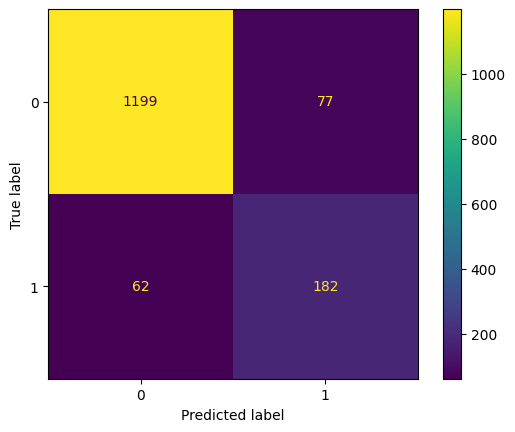

In [8]:
matriz_confusao = confusion_matrix(y_teste, clf.predict_proba(X_teste_new)[:,1] > 0.313385883698052)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao, display_labels = [0, 1])

cm_display.plot()
plt.show()

## Distribuição das probabilidades em treino + validação e teste

O KS, geralmente, é utilizado como uma métrica para avaliar o potencial discriminador de um modelo para duas classes. Aqui, será usado o KS para avaliar o quão próxima a distribuição das probabilidades na base de treino + validação está da distribuição das probabilidades na base de teste. Neste último cenário, curvas próximas são preferidas, pois representa pouca diferença na distribuição das probabilidades entre as bases avaliadas. Como complemento, espera-se um p-valor alto!

In [9]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp
ks_2samp(clf.predict_proba(X_treino_val_new)[:,1], clf.predict_proba(X_teste_new)[:,1])

KstestResult(statistic=0.023180260253282212, pvalue=0.48318263004617723, statistic_location=0.03767352954067992, statistic_sign=1)

In [10]:
acum_treino_val = np.cumsum(clf.predict_proba(X_treino_val_new)[:,1])
acum_teste = np.cumsum(clf.predict_proba(X_teste_new)[:,1])

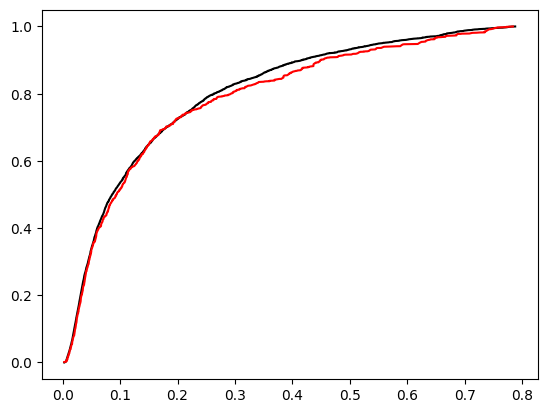

In [11]:
plt.plot(np.sort(clf.predict_proba(X_treino_val_new)[:,1]), acum_treino_val/np.max(acum_treino_val), c='black')
plt.plot(np.sort(clf.predict_proba(X_teste_new)[:,1]), acum_teste/np.max(acum_teste), c='red')
plt.show()

Outra forma de graficar o KS. Defina as probabilidades de treino + validação com label = 1 e as probabilidades de teste com label = 0. 

Abaixo, foi feito um teste com o pacote scikitplot (https://scikit-plot.readthedocs.io/en/stable/index.html), entretanto, foi necessário fazer downgrade. Mesmo com o downgradem não foi possível fazer o gráfico! De acordo com o github apontado abaixo, este pacote: "long-term I guess replacing scikit-plot should take place, as it stopped developing on 2018".

In [ ]:
#tamanho_treino = len(clf.predict_proba(X_treino_val_new)[:,1])
#tamanho_teste = len(clf.predict_proba(X_teste_new)[:,1])

In [12]:
#probs = pd.concat([pd.Series(clf.predict_proba(X_treino_val_new)[:,1]), pd.Series(clf.predict_proba(X_teste_new)[:,1])], axis=0).reset_index(drop=True)
#labels = pd.concat([pd.Series(np.ones(tamanho_treino, dtype=int)), pd.Series(np.zeros(tamanho_teste,dtype=int))], axis=0).reset_index(drop=True)

#aux = pd.concat([probs, labels], axis=1).rename(columns={0:'probs', 1:'labels'})
#aux.head()

In [13]:
#import scipy
#scipy.__version__

In [12]:
#!pip install scipy==1.12.0

In [11]:
# Erro: ImportError: cannot import name 'interp' from 'scipy'. Faremos o downgrade do pacote scipy
# https://github.com/mljar/mljar-supervised/issues/691
#import scikitplot as skplt

#skplt.metrics.plot_ks_statistic(y_probas=aux['probs'], y_true=aux['labels'])
#plt.show()

Outra forma de se graficar a curva de distribuição acumulada é usando o pacote seaborn.

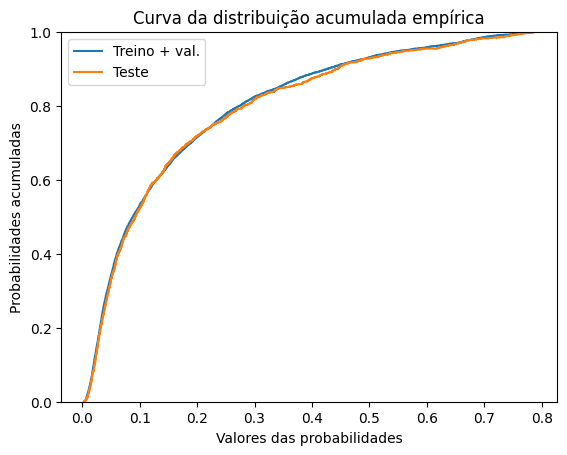

In [20]:
sns.ecdfplot(clf.predict_proba(X_treino_val_new)[:,1], label = 'Treino + val.')
sns.ecdfplot(clf.predict_proba(X_teste_new)[:,1], label = 'Teste')
plt.title('Curva da distribuição acumulada empírica')
plt.xlabel('Valores das probabilidades')
plt.ylabel('Probabilidades acumuladas')
plt.legend()
plt.show()

# Perfil de eficiência acumulada (CAP)

Também conhecida como Curva de Lorentz, ela nos informa do percentual total da base (% do Total no eixo x) qual a concentração de maus que se tem (% maus na amostra). Abaixo, segue um exemplo de gráfico e a sua interpretação.

https://medium.com/towards-data-science/machine-learning-classifier-evaluation-using-roc-and-cap-curves-7db60fe6b716

In [202]:
total = len(y_teste)
probs = clf.predict_proba(X_teste_new)[:,1]
model_y = [y for _, y in sorted(zip(probs, y_teste), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)

In [206]:
sorted(zip(probs, y_teste), reverse = True)

[(0.7838079355273243, 1),
 (0.7833610545606354, 1),
 (0.7721753701546871, 1),
 (0.7721680143409713, 1),
 (0.772075295550857, 1),
 (0.766162265205303, 1),
 (0.7654574920405735, 1),
 (0.7624086566221537, 1),
 (0.7614991518601094, 1),
 (0.7568617828858305, 1),
 (0.7560008721136592, 1),
 (0.7516640788572874, 1),
 (0.7493891692665342, 1),
 (0.745585278290285, 1),
 (0.7444315017292035, 1),
 (0.7425533524780605, 1),
 (0.7393401499622445, 1),
 (0.736915118391339, 1),
 (0.7347692729040306, 1),
 (0.7347186289781674, 1),
 (0.7342239412677098, 1),
 (0.7259916506409528, 1),
 (0.7205974134514058, 1),
 (0.7133107916631221, 1),
 (0.7080822302484098, 1),
 (0.7057650241086024, 1),
 (0.6943898023507534, 1),
 (0.6933641433613863, 0),
 (0.6876803972057965, 1),
 (0.6859356969910203, 1),
 (0.6854344067323634, 0),
 (0.681567957270525, 1),
 (0.6783063046580288, 1),
 (0.6724341691348598, 1),
 (0.6698951367418452, 1),
 (0.6675177084011017, 1),
 (0.6669500708661843, 1),
 (0.6669473028205471, 1),
 (0.6665113754629

In [213]:
200/1521*100, 150/244*100

(13.149243918474687, 61.47540983606557)

- Para os primeiros 100 clientes, observa-se que aproximadamente 95 são "maus" clientes ou clientes que são altamente propensos a ser churn. Isso equivale a $100/1521 \approx 6.57\%$ de toda a base e a $95/244 \approx 38.93\%$ de todos os maus.
- Para os primeiros 200 clientes, observa-se que aproximadamente 150 são "maus" clientes ou clientes que são altamente propensos a ser churn. Isso equivale a $200/1521 \approx 13.14\%$ de toda a base e a $150/244 \approx 61.47\%$ de todos os maus.

In [201]:
150/200, 95/100

(0.75, 0.95)

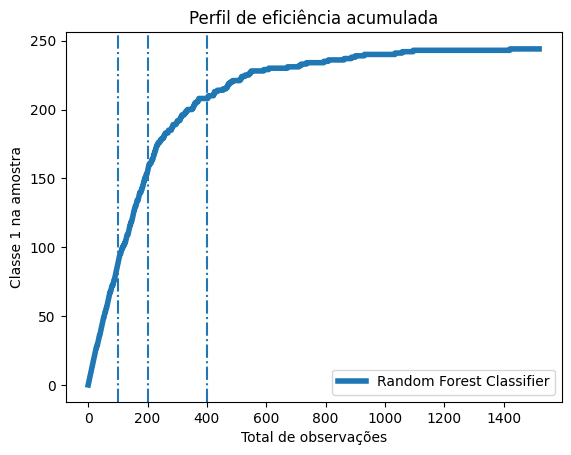

In [205]:
plt.plot(x_values, 
         y_values, 
         label = 'Random Forest Classifier', 
         linewidth = 4)

plt.axvline(x=100, linestyle='-.')
plt.axvline(x=200, linestyle='-.')
plt.axvline(x=400, linestyle='-.')

plt.xlabel('Total de observações')
plt.ylabel('Classe 1 na amostra')
plt.title('Perfil de eficiência acumulada')
plt.legend(loc = 'lower right')
plt.show()

# XGBoost

## Log do melhor modelo

In [7]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri='http://127.0.0.1:5000')
parametros = mlflow_client.get_run('c7b11305d2a04d75b9f42036a478fa58').data.to_dictionary()['params']
parametros

{'sampling_method': 'None',
 'reg_lambda': 'None',
 'multi_strategy': 'None',
 'min_child_weight': '208',
 'tree_method': 'None',
 'validate_parameters': 'None',
 'grow_policy': 'None',
 'n_estimators': '256',
 'gamma': 'None',
 'subsample': '0.9500000000000001',
 'monotone_constraints': 'None',
 'feature_types': 'None',
 'importance_type': 'None',
 'enable_categorical': 'False',
 'colsample_bylevel': 'None',
 'device': 'None',
 'colsample_bytree': '0.55',
 'base_score': '0.75',
 'colsample_bynode': '0.6000000000000001',
 'max_leaves': 'None',
 'reg_alpha': 'None',
 'learning_rate': '0.05',
 'max_delta_step': 'None',
 'max_bin': 'None',
 'objective': 'binary:logistic',
 'callbacks': 'None',
 'early_stopping_rounds': 'None',
 'verbosity': 'None',
 'max_depth': '239',
 'max_cat_threshold': 'None',
 'booster': 'None',
 'n_jobs': 'None',
 'num_parallel_tree': 'None',
 'random_state': 'None',
 'scale_pos_weight': 'None',
 'max_cat_to_onehot': 'None',
 'interaction_constraints': 'None',
 'mi

In [10]:
XGB = xgb.XGBClassifier(min_child_weight = 208,
                        n_estimators = 256,
                        subsample = 0.9500000000000001,
                        colsample_bytree = 0.55,
                        base_score = 0.75,
                        colsample_bynode = 0.6000000000000001,
                        learning_rate = 0.05,
                        objective = 'binary:logistic',
                        max_depth = 239)
XGB.fit(X_treino_val_new, y_treino_val)

XGBClassifier(base_score=0.75, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.6000000000000001,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=239, max_leaves=None,
              min_child_weight=208, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
experiment = mlflow.set_experiment(experiment_id='323420677015884888')

In [15]:
experiment.experiment_id

'323420677015884888'

In [ ]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'XGB_Final', experiment_id = experiment.experiment_id) as run: 

        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_teste_new, XGB.predict_proba(X_teste_new))
        mlflow.sklearn.log_model(XGB, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [17]:
log_XGB = 'runs:/7d261fd978944b408e29700a7c4b5a98/modelo'
clf = mlflow.sklearn.load_model(log_XGB)

In [18]:
print('Auc_Pr_Teste:', average_precision_score(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('Auc_Roc_Teste:', roc_auc_score(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('BS_Teste:', brier_score_loss(y_teste, clf.predict_proba(X_teste_new)[:,1]))
print('Log_Loss_Teste:', log_loss(y_teste, clf.predict_proba(X_teste_new)[:,1]))

print('-------------------------------Sem ponto de corte ótimo-------------------------------')

# Sem ponto de corte ótimo
print('F1_Score_Teste:', f1_score(y_teste, clf.predict(X_teste_new)))
print('Precisao_Teste:', precision_score(y_teste, clf.predict(X_teste_new)))
print('Recall_Teste:', recall_score(y_teste, clf.predict(X_teste_new)))

print('-------------------------------Com ponto de corte ótimo-------------------------------')

# Sem ponto de corte ótimo
print('F1_Score_Teste:', f1_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.32041183))
print('Precisao_Teste:', precision_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.32041183))
print('Recall_Teste:', recall_score(y_teste, clf.predict_proba(X_teste_new)[:,1] >= 0.32041183))

Auc_Pr_Teste: 0.7310623678175322
Auc_Roc_Teste: 0.9034412097230073
BS_Teste: 0.0762433157715999
Log_Loss_Teste: 0.26126350741902343
-------------------------------Sem ponto de corte ótimo-------------------------------
F1_Score_Teste: 0.6208651399491094
Precisao_Teste: 0.8187919463087249
Recall_Teste: 0.5
-------------------------------Com ponto de corte ótimo-------------------------------
F1_Score_Teste: 0.6789366053169734
Precisao_Teste: 0.6775510204081633
Recall_Teste: 0.680327868852459


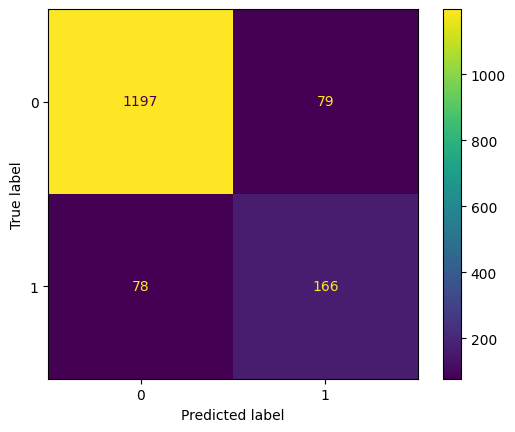

In [19]:
matriz_confusao = confusion_matrix(y_teste, clf.predict_proba(X_teste_new)[:,1] > 0.32041183)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao, display_labels = [0, 1])

cm_display.plot()
plt.show()

## Distribuição das probabilidades em treino + validação e teste

In [20]:
ks_2samp(clf.predict_proba(X_treino_val_new)[:,1], clf.predict_proba(X_teste_new)[:,1])

KstestResult(statistic=0.02511037527593819, pvalue=0.38214106691894273, statistic_location=0.02488191, statistic_sign=1)

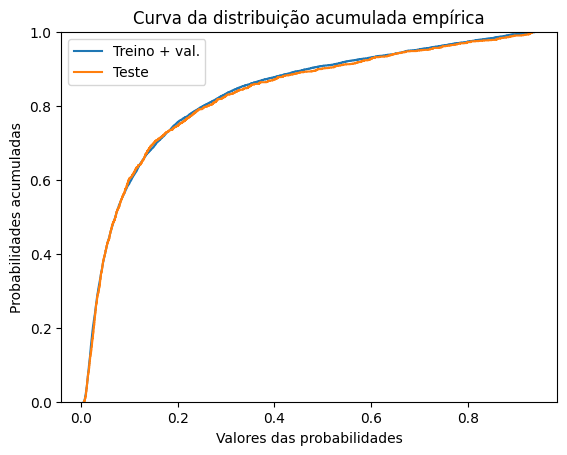

In [21]:
sns.ecdfplot(clf.predict_proba(X_treino_val_new)[:,1], label = 'Treino + val.')
sns.ecdfplot(clf.predict_proba(X_teste_new)[:,1], label = 'Teste')
plt.title('Curva da distribuição acumulada empírica')
plt.xlabel('Valores das probabilidades')
plt.ylabel('Probabilidades acumuladas')
plt.legend()
plt.show()

## CAP

A curva difere em pequenos valores comparado com os valores da RF. Observe os valores nas linhas tracejadas.

In [23]:
clf

XGBClassifier(base_score=0.75, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.6000000000000001,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=239, max_leaves=None,
              min_child_weight=208, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

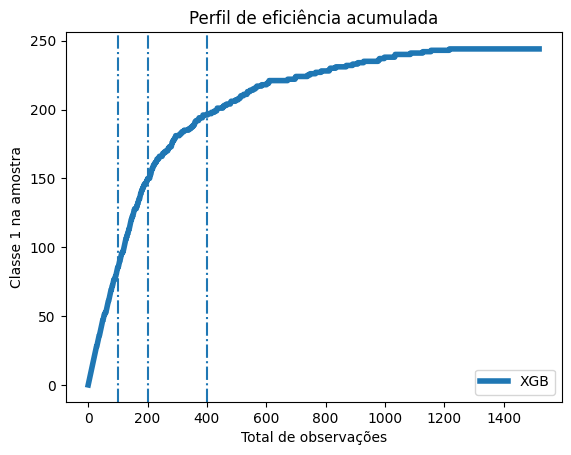

In [24]:
total = len(y_teste)
probs = clf.predict_proba(X_teste_new)[:,1]
model_y = [y for _, y in sorted(zip(probs, y_teste), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)


plt.plot(x_values, 
         y_values, 
         label = 'XGB', 
         linewidth = 4)

plt.axvline(x=100, linestyle='-.')
plt.axvline(x=200, linestyle='-.')
plt.axvline(x=400, linestyle='-.')

plt.xlabel('Total de observações')
plt.ylabel('Classe 1 na amostra')
plt.title('Perfil de eficiência acumulada')
plt.legend(loc = 'lower right')
plt.show()

# Blend

In [31]:
def Config_Vars(X):
    # Função que configura a matriz X para ser aplicada no modelo

    # RF
    logged_model_rf = 'runs:/49c8f322c903413b89a06aa02e2e3a4a/modelo'
    rf = mlflow.sklearn.load_model(logged_model_rf)

    # Xgboost
    logged_model_xgb = 'runs:/7d261fd978944b408e29700a7c4b5a98/modelo'
    XGB = mlflow.sklearn.load_model(logged_model_xgb)

    # Aplica RF
    x_rf = rf.predict_proba(X)[:,1]

    # Aplica Xgboost
    x_xgb = XGB.predict_proba(X)[:,1]

    X_pred = pd.concat([pd.Series(x_rf).reset_index(drop=True), pd.Series(x_xgb).reset_index(drop=True)],axis=1).rename(columns={0: 'rf', 1: 'xgb'})

    return X_pred

In [36]:
with open(os.getcwd() + '/Config_Vars_Final.pkl','wb') as f:
    pickle.dump(Config_Vars, f)

In [32]:
X_pred = Config_Vars(X_treino_val_new)
X_pred.head()

,rf,xgb
0,0.027028,0.036682
1,0.214064,0.097759
2,0.040882,0.037428
3,0.013580,0.049576
4,0.601645,0.852290


In [33]:
bag_blend = BaggingClassifier(DecisionTreeClassifier(max_depth=10, random_state=123),
                              n_estimators=10,
                              max_samples=math.ceil(.5*X_pred.shape[0]),
                              bootstrap=False, # Configurando para True, trata-se do bagging
                              n_jobs=-1,
                              random_state=123)
bag_blend.fit(X = X_pred, y = y_treino_val)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(max_depth=10,
                                                   random_state=123),
                  max_samples=4304, n_jobs=-1, random_state=123)

In [38]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Blend_Final', experiment_id = experiment.experiment_id) as run: 

        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(Config_Vars(X_teste_new), bag_blend.predict_proba(Config_Vars(X_teste_new)))
        mlflow.sklearn.log_model(bag_blend, signature=signature, artifact_path='modelo')
        mlflow.log_artifact(os.getcwd() + '/Config_Vars_Final.pkl', artifact_path='Configs')

In [39]:
print('Auc_Pr_Teste:', average_precision_score(y_teste, bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1]))
print('Auc_Roc_Teste:', roc_auc_score(y_teste, bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1]))
print('BS_Teste:', brier_score_loss(y_teste, bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1]))
print('Log_Loss_Teste:', log_loss(y_teste, bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1]))

print('-------------------------------Sem ponto de corte ótimo-------------------------------')

# Sem ponto de corte ótimo
print('F1_Score_Teste:', f1_score(y_teste, bag_blend.predict(Config_Vars(X_teste_new))))
print('Precisao_Teste:', precision_score(y_teste, bag_blend.predict(Config_Vars(X_teste_new))))
print('Recall_Teste:', recall_score(y_teste, bag_blend.predict(Config_Vars(X_teste_new))))

Auc_Pr_Teste: 0.7363171782872766
Auc_Roc_Teste: 0.9195696721311476
BS_Teste: 0.07386356606291129
Log_Loss_Teste: 0.31546716824722776
-------------------------------Sem ponto de corte ótimo-------------------------------
F1_Score_Teste: 0.6782608695652174
Precisao_Teste: 0.7222222222222222
Recall_Teste: 0.639344262295082


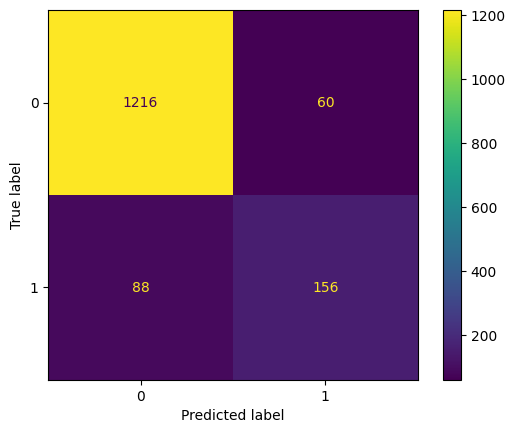

In [40]:
matriz_confusao = confusion_matrix(y_teste, bag_blend.predict(Config_Vars(X_teste_new)))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [41]:
ks_2samp(bag_blend.predict_proba(Config_Vars(X_treino_val_new))[:,1], bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1])

KstestResult(statistic=0.03210613454165214, pvalue=0.1360467694735689, statistic_location=0.0, statistic_sign=1)

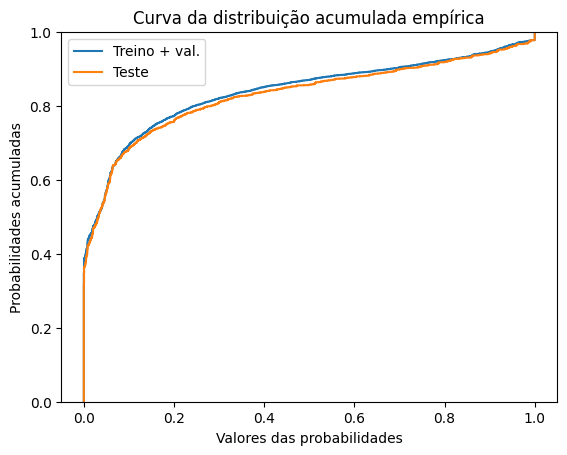

In [43]:
sns.ecdfplot(bag_blend.predict_proba(Config_Vars(X_treino_val_new))[:,1], label = 'Treino + val.')
sns.ecdfplot(bag_blend.predict_proba(Config_Vars(X_teste_new))[:,1], label = 'Teste')
plt.title('Curva da distribuição acumulada empírica')
plt.xlabel('Valores das probabilidades')
plt.ylabel('Probabilidades acumuladas')
plt.legend()
plt.show()

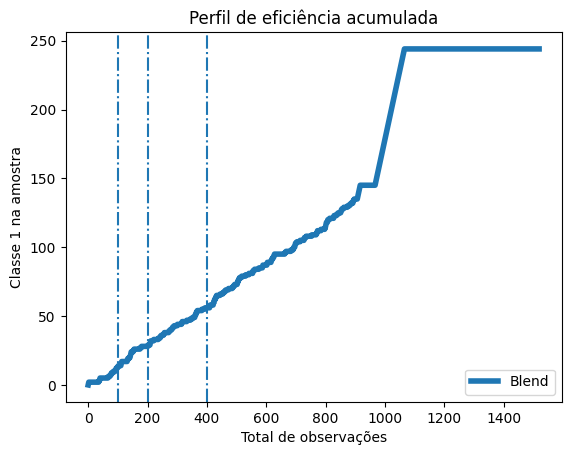

In [44]:
total = len(y_teste)
probs = bag_blend.predict_proba(Config_Vars(X_treino_val_new))[:,1]
model_y = [y for _, y in sorted(zip(probs, y_teste), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)

plt.plot(x_values, 
         y_values, 
         label = 'Blend', 
         linewidth = 4)

plt.axvline(x=100, linestyle='-.')
plt.axvline(x=200, linestyle='-.')
plt.axvline(x=400, linestyle='-.')

plt.xlabel('Total de observações')
plt.ylabel('Classe 1 na amostra')
plt.title('Perfil de eficiência acumulada')
plt.legend(loc = 'lower right')
plt.show()

# PSI

Uma regra empírica para avaliar o PSI é apresentada em Thomas, Edelman e Crook, 2002:

- $PSI \leq 0.1$, não houve alteração;
- $0.1 < PSI \leq 0.25$ possível alteração;
- $PSI > 0.25$ mudanças significantes de perfil.

As variáveis utilizadas na base de treino não tiveram alterações na base de teste.

In [45]:
X_treino_val_new.columns

Index(['Customer_Age', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1',
       'Total_Ct_Chng_Q4_Q1', 'vfm', 'pmcc', 'Income_Category_1.40k',
       'Income_Category_2.40k_60k', 'Income_Category_3.60k_80k',
       'Income_Category_4.80k_120k', 'Income_Category_5.120k',
       'Education_Level_v2_1.Uneducated', 'Education_Level_v2_2.High School',
       'Education_Level_v2_3.Graduate', 'Education_Level_v2_4.Post-Graduate'],
      dtype='object')

In [15]:
cortes_idade = Funcoes.Categorizacao(X_treino_val_new, 5, 'Customer_Age')
cortes_Rev_Bal = Funcoes.Categorizacao(X_treino_val_new, 3, 'Total_Revolving_Bal')
cortes_vfm = Funcoes.Categorizacao(X_treino_val_new, 3, 'vfm')
cortes_pmcc = Funcoes.Categorizacao(X_treino_val_new, 3, 'pmcc')
cortes_Amt = Funcoes.Categorizacao(X_treino_val_new, 2, 'Total_Amt_Chng_Q4_Q1')
cortes_Ct = Funcoes.Categorizacao(X_treino_val_new, 3, 'Total_Ct_Chng_Q4_Q1')

In [16]:
X_treino_val_new = X_treino_val_new.assign(Customer_Age_Cat = pd.cut(X_treino_val_new['Customer_Age'], bins = cortes_idade[1], include_lowest=True))
X_teste_new = X_teste_new.assign(Customer_Age_Cat = pd.cut(X_teste_new['Customer_Age'], bins = cortes_idade[1], include_lowest=True))

X_treino_val_new = X_treino_val_new.assign(Total_Revolving_Bal_Cat = pd.cut(X_treino_val_new['Total_Revolving_Bal'], bins = cortes_Rev_Bal[1], include_lowest=True))
X_teste_new = X_teste_new.assign(Total_Revolving_Bal_Cat = pd.cut(X_teste_new['Total_Revolving_Bal'], bins = cortes_Rev_Bal[1], include_lowest=True))

X_treino_val_new = X_treino_val_new.assign(vfm_Cat = pd.cut(X_treino_val_new['vfm'], bins = cortes_vfm[1], include_lowest=True))
X_teste_new = X_teste_new.assign(vfm_Cat = pd.cut(X_teste_new['vfm'], bins = cortes_vfm[1], include_lowest=True))

X_treino_val_new = X_treino_val_new.assign(pmcc_Cat = pd.cut(X_treino_val_new['pmcc'], bins = cortes_pmcc[1], include_lowest=True))
X_teste_new = X_teste_new.assign(pmcc_Cat = pd.cut(X_teste_new['pmcc'], bins = cortes_pmcc[1], include_lowest=True))

X_treino_val_new = X_treino_val_new.assign(Total_Amt_Chng_Q4_Q1_Cat = pd.cut(X_treino_val_new['Total_Amt_Chng_Q4_Q1'], bins = cortes_Amt[1], include_lowest=True))
X_teste_new = X_teste_new.assign(Total_Amt_Chng_Q4_Q1_Cat = pd.cut(X_teste_new['Total_Amt_Chng_Q4_Q1'], bins = cortes_Amt[1], include_lowest=True))

X_treino_val_new = X_treino_val_new.assign(Total_Ct_Chng_Q4_Q1_Cat = pd.cut(X_treino_val_new['Total_Ct_Chng_Q4_Q1'], bins = cortes_Ct[1], include_lowest=True))
X_teste_new = X_teste_new.assign(Total_Ct_Chng_Q4_Q1_Cat = pd.cut(X_teste_new['Total_Ct_Chng_Q4_Q1'], bins = cortes_Ct[1], include_lowest=True))

In [8]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Customer_Age_Cat')

,Customer_Age_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-2.54, -0.91]",0.201696,0.197368,0.004328,0.021691,0.000094,0.00247
1,"(-0.91, -0.283]",0.213082,0.200658,0.012424,0.060077,0.000746,0.00247
2,"(-0.283, 0.219]",0.190775,0.187500,0.003275,0.017316,0.000057,0.00247
3,"(0.219, 0.845]",0.205414,0.223684,-0.018270,-0.085207,0.001557,0.00247
4,"(0.845, 3.353]",0.189032,0.190789,-0.001757,-0.009253,0.000016,0.00247


In [9]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Total_Relationship_Count')

,Total_Relationship_Count,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,-1.811975,0.090392,0.086842,0.003549,0.040059,0.000142,0.003556
1,-1.168954,0.120716,0.134211,-0.013495,-0.105971,0.001430,0.003556
2,-0.525933,0.225514,0.239474,-0.013960,-0.060061,0.000838,0.003556
3,0.117089,0.190543,0.178947,0.011595,0.062784,0.000728,0.003556
4,0.760110,0.187754,0.180921,0.006833,0.037073,0.000253,0.003556
5,1.403132,0.185082,0.179605,0.005477,0.030037,0.000165,0.003556


In [10]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Months_Inactive_12_mon')

,Months_Inactive_12_mon,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,-2.327756,0.003021,0.001974,0.001047,0.425619,0.000446,0.002812
1,-1.337898,0.218311,0.232895,-0.014584,-0.064667,0.000943,0.002812
2,-0.348040,0.324271,0.323026,0.001245,0.003846,0.000005,0.002812
3,0.641818,0.381201,0.371711,0.009491,0.025212,0.000239,0.002812
4,1.631675,0.043337,0.040789,0.002547,0.060579,0.000154,0.002812
5,2.621533,0.018009,0.015132,0.002877,0.174065,0.000501,0.002812
6,3.611391,0.011851,0.014474,-0.002623,-0.199935,0.000524,0.002812


In [11]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Contacts_Count_12_mon')

,Contacts_Count_12_mon,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,-2.229514,0.039387,0.039474,-0.000087,-0.002210,1.925711e-07,0.006096
1,-1.320028,0.148484,0.145395,0.003089,0.021023,6.494258e-05,0.006096
2,-0.410543,0.320088,0.310526,0.009562,0.030328,2.899982e-04,0.006096
3,0.498943,0.335773,0.322368,0.013405,0.040741,5.461231e-04,0.006096
4,1.408428,0.134890,0.151974,-0.017083,-0.119246,2.037140e-03,0.006096
5,2.317913,0.016266,0.023684,-0.007418,-0.375742,2.787397e-03,0.006096
6,3.227399,0.005112,0.006579,-0.001467,-0.252261,3.700238e-04,0.006096


In [14]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Total_Revolving_Bal_Cat')

,Total_Revolving_Bal_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-1.4109999999999998, -0.373]",0.333333,0.322368,0.010965,0.033448,0.000367,0.000631
1,"(-0.373, 0.554]",0.333450,0.342763,-0.009314,-0.027548,0.000257,0.000631
2,"(0.554, 1.667]",0.333217,0.334868,-0.001651,-0.004943,0.000008,0.000631


In [17]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'vfm_Cat')

,vfm_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-1.5699999999999998, -0.454]",0.333333,0.329605,0.003728,0.011247,0.000042,0.000802
1,"(-0.454, -0.0424]",0.333333,0.323684,0.009649,0.029375,0.000283,0.000802
2,"(-0.0424, 4.846]",0.333333,0.346053,-0.012719,-0.037448,0.000476,0.000802


In [18]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'pmcc_Cat')

,pmcc_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-1.091, -0.663]",0.333333,0.326974,0.006360,0.019263,0.000123,0.000189
1,"(-0.663, 0.225]",0.333333,0.335526,-0.002193,-0.006557,0.000014,0.000189
2,"(0.225, 4.269]",0.333333,0.337500,-0.004167,-0.012423,0.000052,0.000189


In [19]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Total_Amt_Chng_Q4_Q1_Cat')

,Total_Amt_Chng_Q4_Q1_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-3.472, -0.109]",0.501568,0.505921,-0.004353,-0.008640,0.000038,0.000076
1,"(-0.109, 12.023]",0.498432,0.494079,0.004353,0.008771,0.000038,0.000076


In [20]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Total_Ct_Chng_Q4_Q1_Cat')

,Total_Ct_Chng_Q4_Q1_Cat,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,"(-2.987, -0.358]",0.335192,0.355263,-0.020071,-0.058154,0.001167,0.0018
1,"(-0.358, 0.262]",0.332055,0.323684,0.008371,0.025533,0.000214,0.0018
2,"(0.262, 12.557]",0.332752,0.321053,0.011700,0.035794,0.000419,0.0018


In [21]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Income_Category_1.40k')

,Income_Category_1.40k,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.64831,0.648684,-0.000375,-0.000578,2.164950e-07,6.159122e-07
1,1,0.35169,0.351316,0.000375,0.001066,3.994171e-07,6.159122e-07


In [22]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Income_Category_2.40k_60k')

,Income_Category_2.40k_60k,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.823051,0.824342,-0.001291,-0.001567,0.000002,0.000011
1,1,0.176949,0.175658,0.001291,0.007323,0.000009,0.000011


In [23]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Income_Category_3.60k_80k')

,Income_Category_3.60k_80k,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.859649,0.872368,-0.012719,-0.014688,0.000187,0.001395
1,1,0.140351,0.127632,0.012719,0.094998,0.001208,0.001395


In [24]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Income_Category_4.80k_120k')

,Income_Category_4.80k_120k,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.847101,0.855921,-0.00882,-0.010358,0.000091,0.000615
1,1,0.152899,0.144079,0.00882,0.059415,0.000524,0.000615


In [25]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Education_Level_v2_1.Uneducated')

,Education_Level_v2_1.Uneducated,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.855583,0.839474,0.016109,0.019008,0.000306,0.00201
1,1,0.144417,0.160526,-0.016109,-0.105751,0.001704,0.00201


In [26]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Education_Level_v2_2.High School')

,Education_Level_v2_2.High School,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.801325,0.800658,0.000667,0.000832,5.547714e-07,0.000003
1,1,0.198675,0.199342,-0.000667,-0.003350,2.232903e-06,0.000003


In [27]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Education_Level_v2_3.Graduate')

,Education_Level_v2_3.Graduate,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.58708,0.613816,-0.026736,-0.044533,0.001191,0.00298
1,1,0.41292,0.386184,0.026736,0.066939,0.001790,0.00298


In [28]:
Funcoes.PSI(X_treino_val_new, X_teste_new, 'Education_Level_v2_4.Post-Graduate')

,Education_Level_v2_4.Post-Graduate,count_treino,count_teste,Dif,Log,PSI_parcial,PSI
0,0,0.905774,0.897368,0.008406,0.009324,0.000078,0.000797
1,1,0.094226,0.102632,-0.008406,-0.085453,0.000718,0.000797
